# Prédire la consommation d'énergie des bâtiments

## Analyse Exploratoire des Données (EDA)

### Import des modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

### Chargement et premier aperçu des données

In [2]:
building_consumption = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [3]:
# On regarde comment un batiment est défini dans ce jeu de données 
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [4]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

### Nettoyage initial et filtrage

Nous nous concentrons sur les bâtiments non destinés à l'habitation.

In [5]:
print("Nombre de bâtiments:", len(building_consumption))
building_consumption['BuildingType'].value_counts()

Nombre de bâtiments: 3376


BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [6]:
residential_building_types = [
    'Multifamily LR (1-4)',
    'Multifamily MR (5-9)',
    'Multifamily HR (10+)'
]

# conserver uniquement les bâtiments non résidentiels
df_non_residential = building_consumption[
    ~building_consumption['BuildingType'].isin(residential_building_types)
].copy()

print("Nombre de bâtiments non résidentiels :", len(df_non_residential))
print(df_non_residential['BuildingType'].value_counts())

Nombre de bâtiments non résidentiels : 1668
BuildingType
NonResidential        1460
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Nonresidential WA        1
Name: count, dtype: int64


### Gestion des outliers

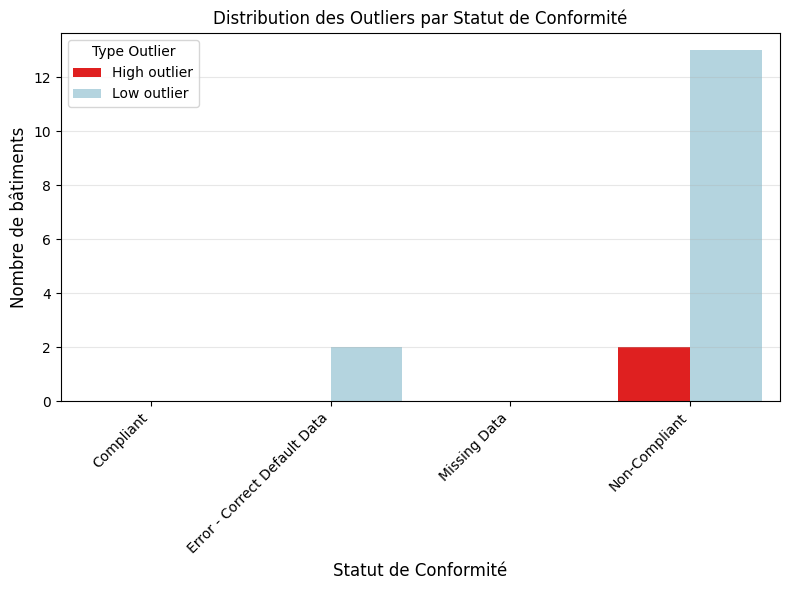

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_non_residential, x='ComplianceStatus', hue='Outlier', 
              palette={'Low outlier': 'lightblue', 'High outlier': 'red'})
plt.title('Distribution des Outliers par Statut de Conformité')
plt.xlabel('Statut de Conformité', fontsize=12)
plt.ylabel('Nombre de bâtiments', fontsize=12)
plt.legend(title='Type Outlier')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Le graphique révèle que les problèmes de conformité et les anomalies de données sont corrélés : tous les outliers significatifs apparaissent dans les bâtiments non-conformes. Cela justifie une attention particulière sur ces 2 bâtiments avec des valeurs aberrantes pour comprendre s'il s'agit d'erreurs de saisie ou de cas réellement exceptionnels.

In [8]:
# Suppression des outliers
print(f"Taille originale : {len(df_non_residential)}")
df = df_non_residential[
    ~df_non_residential['Outlier'].isin(['High outlier', 'Low outlier']) &
    ~df_non_residential['ComplianceStatus'].isin(['Error - Correct Default Data', 'Non-Compliant'])
]

print(f"Taille après supression : {len(df)}")

Taille originale : 1668
Taille après supression : 1562


### Gestion des valeurs manquantes

In [9]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_table = pd.concat([missing, missing_percent], axis=1, keys=['Total', 'Pourcentage'])
display(missing_table[missing_table['Total'] > 0].sort_values('Pourcentage', ascending=False))

,Total,Pourcentage
Comments,1562,100.000000
Outlier,1562,100.000000
YearsENERGYSTARCertified,1464,93.725992
ThirdLargestPropertyUseType,1214,77.720871
ThirdLargestPropertyUseTypeGFA,1214,77.720871
SecondLargestPropertyUseTypeGFA,720,46.094750
SecondLargestPropertyUseType,720,46.094750
ENERGYSTARScore,565,36.171575
ZipCode,13,0.832266
LargestPropertyUseType,4,0.256082


In [10]:
threshold = 0.5
missing_pct = df.isnull().sum() / len(df)

# Garder seulement les colonnes avec moins de 50% de valeurs manquantes
df_clean = df.loc[:, missing_pct < threshold]

print(f"Nombre de colonnes avant : {df.shape[1]}")
print(f"Nombre de colonnes après : {df_clean.shape[1]}")
print(f"Colonnes supprimées : {df.shape[1] - df_clean.shape[1]}")

Nombre de colonnes avant : 46
Nombre de colonnes après : 41
Colonnes supprimées : 5


### Analyse des variables

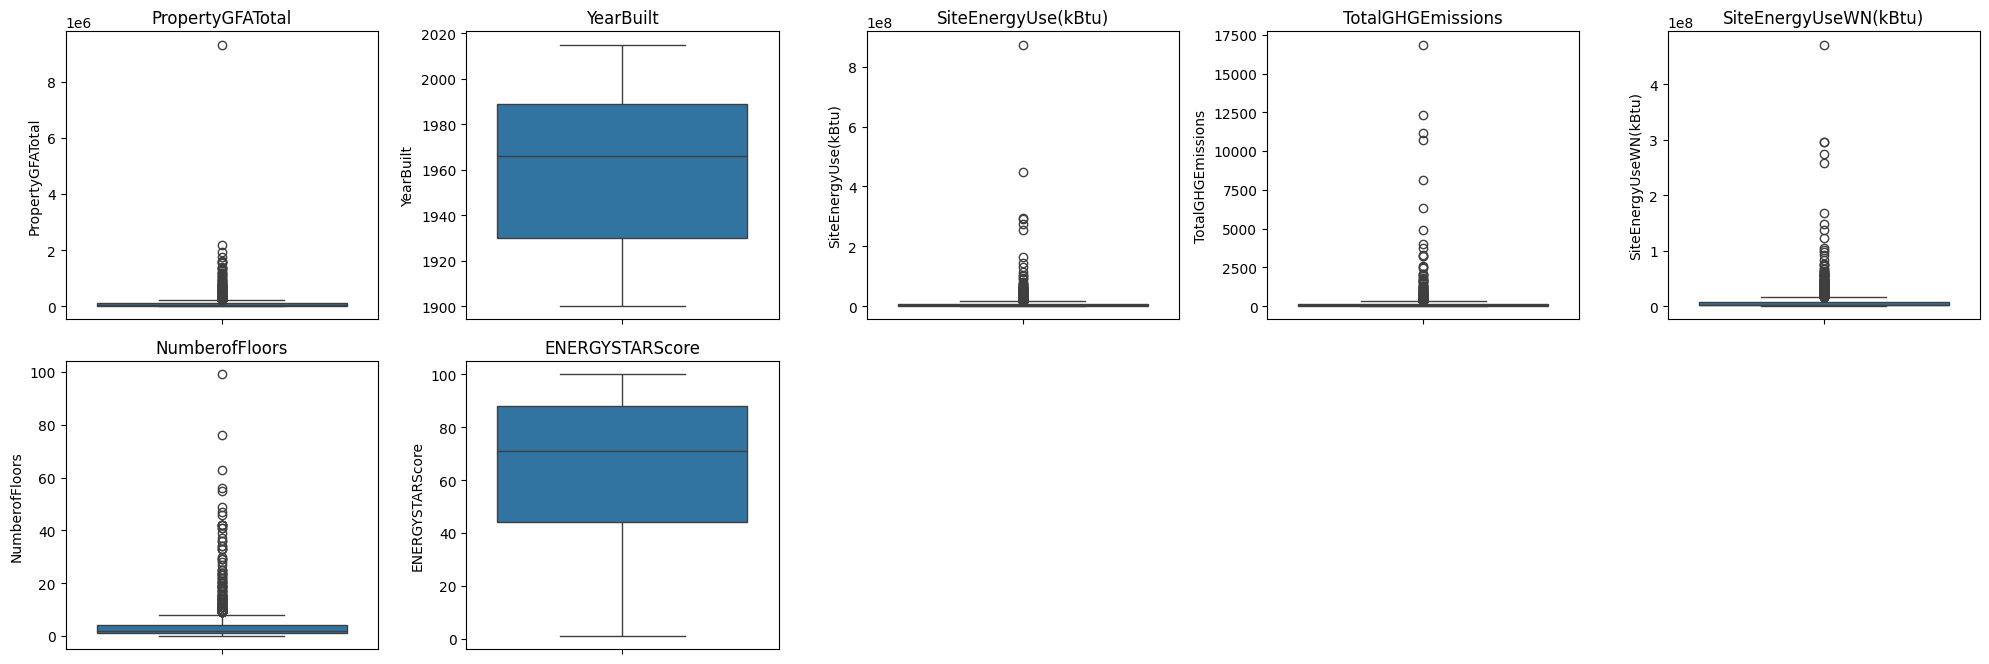

In [11]:
# Variables quantitatives à afficher
quant_vars = ['PropertyGFATotal', 'YearBuilt', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 
              'SiteEnergyUseWN(kBtu)', 'NumberofFloors', 'ENERGYSTARScore']

plt.figure(figsize=(20,10))

for i, var in enumerate(quant_vars):
    plt.subplot(3, 5, i+1)
    sns.boxplot(data = df_clean, y = var)
    plt.title(var)
plt.tight_layout()
plt.show()

Plusieurs variables quantitative sont très asymétriques : PropertyGFATotal, SiteEnergyUse, GHGEmissions, NumberOfFloors. Cela confirme la présence d’outliers importants. D'autres sont plus propres et symétriques : YearBuilt, ENERGYSTARScore.

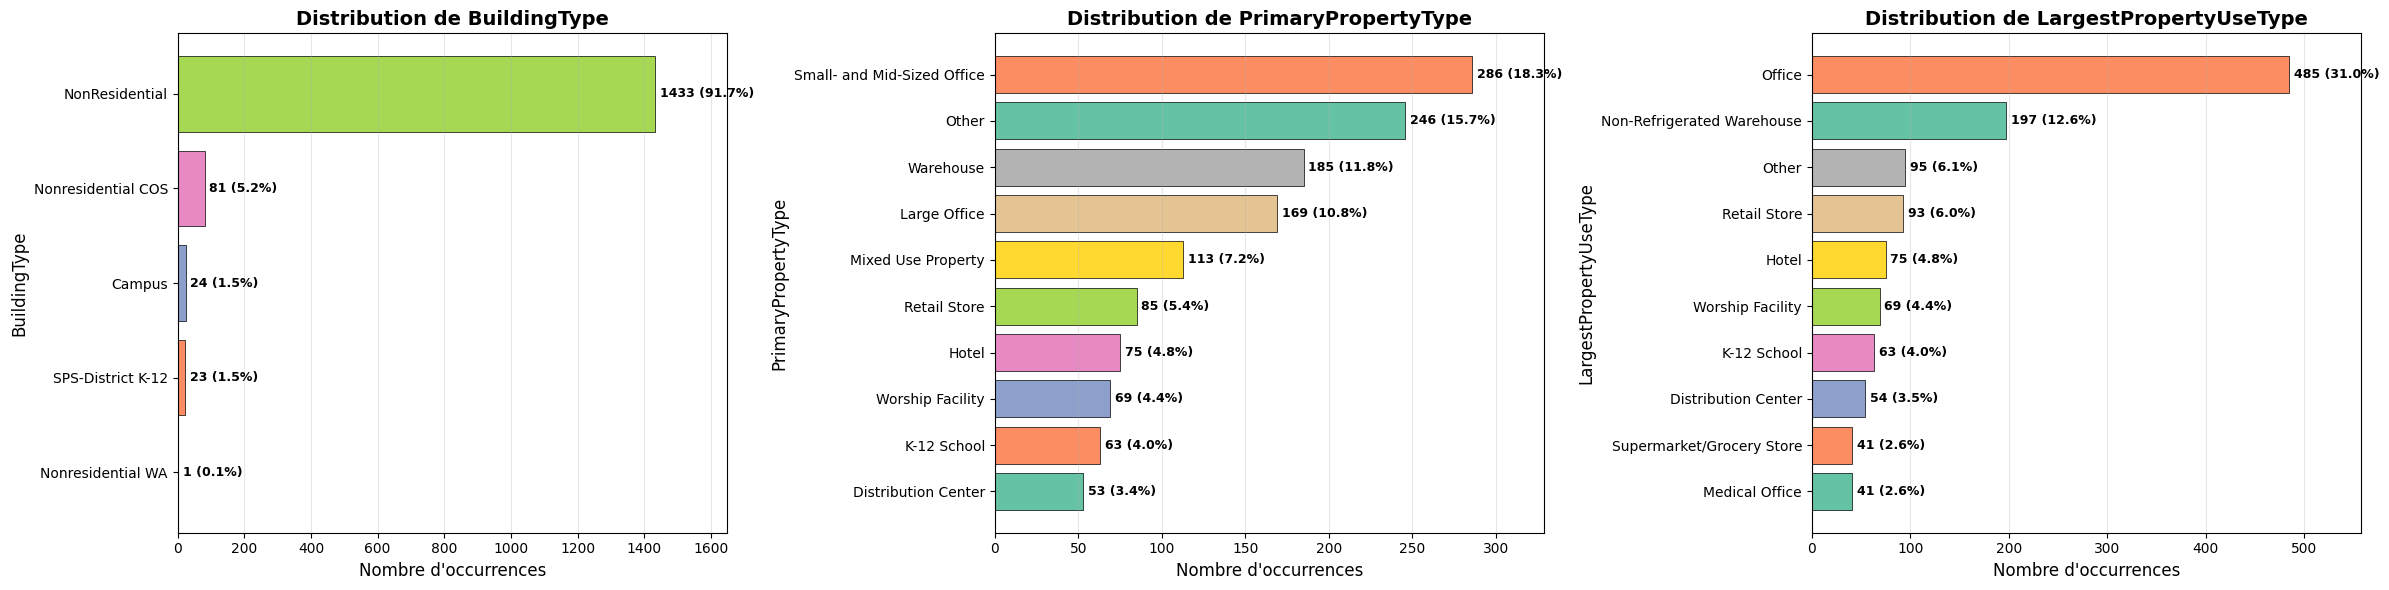

In [12]:
# Variables qualitatives à afficher
qual_var = ['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType']

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, var in enumerate(qual_var):
    if var in df_clean.columns:
        data_to_plot = df_clean[var].dropna()
        
        if len(data_to_plot) == 0:
            continue
        
        value_counts = data_to_plot.value_counts().head(10).iloc[::-1]
        
        colors = sns.color_palette('Set2', len(value_counts))
        y_pos = np.arange(len(value_counts))
        
        axes[i].barh(y_pos, value_counts.values, color=colors, edgecolor='black', linewidth=0.5)
        axes[i].set_yticks(y_pos)
        axes[i].set_yticklabels(value_counts.index, fontsize=10)
        axes[i].set_title(f'Distribution de {var}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Nombre d\'occurrences', fontsize=12)
        axes[i].set_ylabel(var, fontsize=12)
        axes[i].grid(axis='x', alpha=0.3)
        
        total = len(df_clean)
        for j, (label, count) in enumerate(value_counts.items()):
            percentage = (count / total) * 100
            axes[i].text(count + value_counts.max()*0.01, j, 
                        f'{count} ({percentage:.1f}%)', 
                        va='center', ha='left', fontsize=9, fontweight='bold')
       
        axes[i].set_xlim(0, value_counts.max() * 1.15)
plt.tight_layout()
plt.show()

Les variables qualitatives révèlent une forte concentration autour de quelques types de bâtiments. 
Dans BuildingType, la catégorie NonResidential domine largement, ce qui indique que l’échantillon est principalement composé de bâtiments non résidentiels. 
Pour PrimaryPropertyType et LargestPropertyUseType, plusieurs catégories apparaissent, mais quelques-unes ressortent nettement : Small- and Mid-Sized Office, Other, Warehouse, et surtout Office qui est la catégorie d’usage la plus fréquente. 
Globalement, les distributions sont déséquilibrées, montrant une grande diversité de bâtiments mais avec quelques catégories nettement majoritaires.

### Analyse des émissions par type de bâtiment

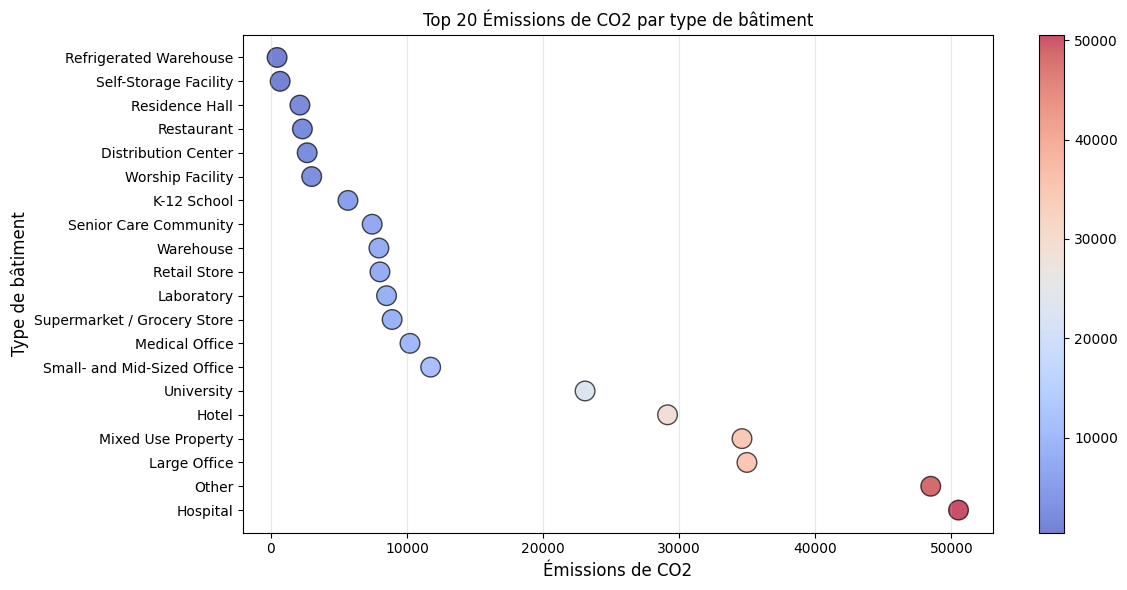

In [13]:
emissions_by_type = (
    df_clean.groupby('PrimaryPropertyType')['TotalGHGEmissions']
      .sum()
      .sort_values(ascending=False)
      .head(20)
)

plt.figure(figsize=(12, 6))

scatter = plt.scatter(emissions_by_type.values, 
                     emissions_by_type.index,
                     s=200,
                     alpha=0.7, 
                     c=emissions_by_type.values,
                     cmap='coolwarm',
                     edgecolors='black', 
                     linewidth=1)

cbar = plt.colorbar(scatter, orientation='vertical')

plt.xlabel("Émissions de CO2", fontsize=12)
plt.ylabel("Type de bâtiment", fontsize=12)
plt.title("Top 20 Émissions de CO2 par type de bâtiment")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Le graphique montre que les hôpitaux dominent largement en raison de leur fonctionnement 24h/24, leurs équipements énergivores et leurs besoins en chauffage/climatisation constants. Les grands bureaux et bâtiments à usage mixte arrivent ensuite, reflétant leur taille importante et leur occupation dense.
Les établissements comme les supermarchés émettent relativement moins malgré leurs systèmes de réfrigération, probablement en raison d'un nombre total de bâtiments plus faible dans l'échantillon analysé.

### Analyse de la relation entre émissions, taille du bâtiment et année de construction

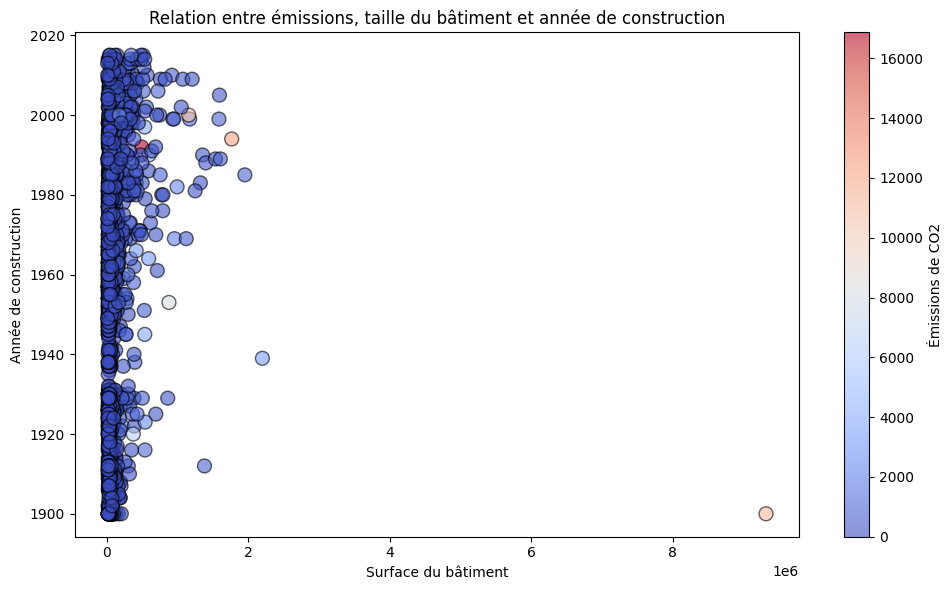

In [14]:
plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    df_clean['PropertyGFATotal'],
    df_clean['YearBuilt'],
    c=df_clean['TotalGHGEmissions'],          
    alpha=0.6,                              
    s=100,                                     
    cmap='coolwarm',
    edgecolors='black', 
    linewidth=1                              
)

plt.xlabel("Surface du bâtiment")
plt.ylabel("Année de construction")
plt.title("Relation entre émissions, taille du bâtiment et année de construction")

cbar = plt.colorbar(scatter)
cbar.set_label("Émissions de CO2")

plt.tight_layout()
plt.show()

Les graphiques révèlent que l'âge et la taille ne sont pas des facteurs déterminants isolés. La performance énergétique dépend davantage de :
L'usage du bâtiment (hôpital vs bureau),
L'efficacité des systèmes (chauffage, climatisation, éclairage),
Les rénovations énergétiques effectuées.
Nous concentrerons les efforts sur les quelques outliers orange plutôt que sur tous les vieux ou grands bâtiments. Un petit nombre de bâtiments inefficaces peut avoir un impact disproportionné.

### Suppression des outliers

In [15]:
def remove_outliers_iqr(df_clean, column, multiplier=1.5):
    """
    Supprime les outliers en utilisant la méthode IQR
    multiplier: 1.5 (standard) ou 3.0 (plus conservateur)
    """
    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    print(f"\n Analyse de {column}")
    
    outliers = df_clean[(df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)]
    print(f"Outliers détectés : {len(outliers)} ({len(outliers)/len(df_clean)*100:.1f}%)")
    
    df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    
    return df_clean, outliers

df_clean, outliers_emissions = remove_outliers_iqr(df_clean, 'TotalGHGEmissions')
df_clean, outliers_emissions = remove_outliers_iqr(df_clean, 'PropertyGFATotal')
df_clean, outliers_emissions = remove_outliers_iqr(df_clean, 'NumberofFloors')

print(f"\nDonnées avant : {len(df)}")
print(f"Données après : {len(df_clean)}")
print(f"Supprimées : {len(df) - len(df_clean)}")


 Analyse de TotalGHGEmissions
Outliers détectés : 169 (10.8%)

 Analyse de PropertyGFATotal
Outliers détectés : 137 (9.8%)

 Analyse de NumberofFloors
Outliers détectés : 58 (4.6%)

Données avant : 1562
Données après : 1198
Supprimées : 364


### Les variables cibles

Les deux variables cibles potentielles sont `SiteEnergyUse(kBtu)` et `SiteEnergyUseWN(kBtu)`. Nous allons les analyser pour choisir celle que nous prédirons.

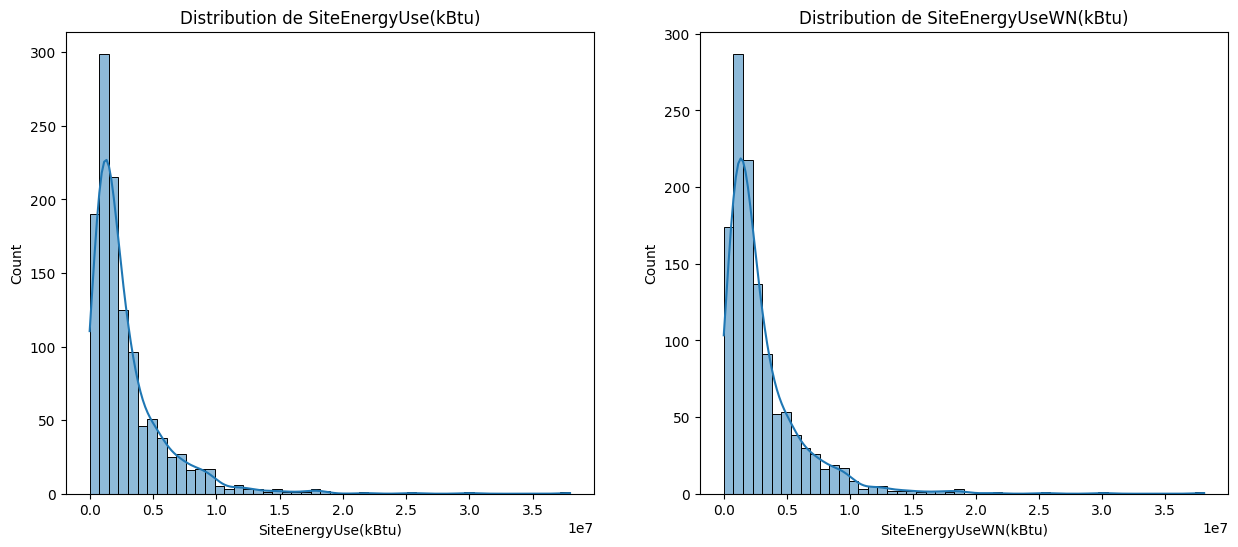

In [16]:
df=df_clean.copy()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['SiteEnergyUse(kBtu)'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution de SiteEnergyUse(kBtu)')
sns.histplot(df['SiteEnergyUseWN(kBtu)'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution de SiteEnergyUseWN(kBtu)')
plt.show()

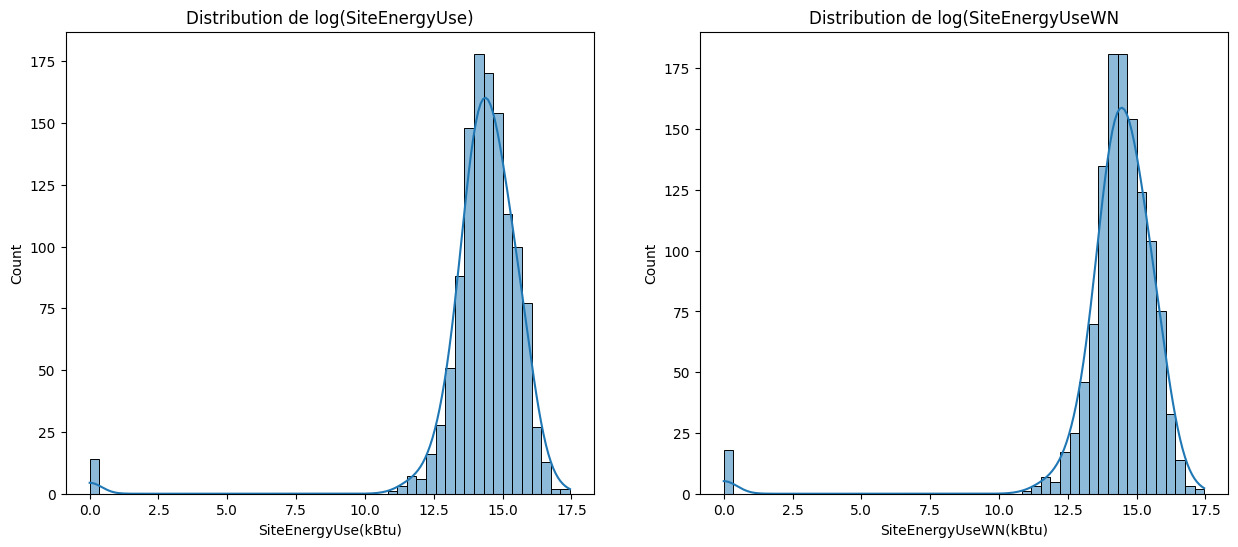

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(np.log1p(df['SiteEnergyUse(kBtu)']), bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution de log(SiteEnergyUse)')
sns.histplot(np.log1p(df['SiteEnergyUseWN(kBtu)']), bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution de log(SiteEnergyUseWN')
plt.show()

Les distributions sont très étalées vers la droite, ce qui indique la présence de valeurs extrêmes. Afin de réduire l’impact de ces outliers et de rendre les données plus symétriques, nous appliquons une transformation logarithmique aux variables fortement asymétriques. Nous choisissons **SiteEnergyUse(kBtu)** comme variable cible pour le reste du projet.

## Feature Engineering & Préparation des données

### Création de nouvelles features

In [18]:
# Âge du bâtiment
if "YearBuilt" in df.columns:
    df['BuildingAge'] = 2016 - df['YearBuilt'] 

# Ratio : surface totale / étages
if {"PropertyGFATotal", "NumberofFloors"}.issubset(df.columns):
     df["GFAPerFloor"] = df["PropertyGFATotal"] / df["NumberofFloors"].replace(0, np.nan)  

# Ratio de Parking: surface du parking / surface totale 
df['parking_ratio'] = (df['PropertyGFAParking'] / df['PropertyGFATotal']).fillna(0)

# Nombre d'Usages: nombre d'usages différents dans ListOfAllPropertyUseTypes
df['NumberOfUseTypes'] = df['ListOfAllPropertyUseTypes'].str.split(',').str.len()
df['NumberOfUseTypes'] = df['NumberOfUseTypes'].fillna(1) 

# Distance approximative au centre-ville de Seattle
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # rayon terrestre en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))
if {"Latitude", "Longitude"}.issubset(df.columns):
     df["DistanceFromCenter"] = haversine(df["Latitude"], df["Longitude"], 47.6062, -122.3321)

### Suppression des colonnes non pertinentes

In [19]:
df.corr(numeric_only=True)['SiteEnergyUse(kBtu)'].sort_values()

OSEBuildingID                     -0.284416
ENERGYSTARScore                   -0.273783
BuildingAge                       -0.148547
ZipCode                           -0.025308
Longitude                         -0.006235
DistanceFromCenter                -0.005006
SteamUse(kBtu)                     0.010188
Latitude                           0.056676
CouncilDistrictCode                0.059331
NumberofBuildings                  0.062781
NumberOfUseTypes                   0.108701
parking_ratio                      0.143932
YearBuilt                          0.148547
NumberofFloors                     0.153294
PropertyGFAParking                 0.221035
GFAPerFloor                        0.265315
SecondLargestPropertyUseTypeGFA    0.319919
GHGEmissionsIntensity              0.395624
LargestPropertyUseTypeGFA          0.408807
PropertyGFABuilding(s)             0.444412
PropertyGFATotal                   0.471521
NaturalGas(kBtu)                   0.517194
NaturalGas(therms)              

In [20]:
columns_to_drop = [
    'OSEBuildingID', 'DataYear', 'BuildingType', 'Latitude', 'Longitude', 'PropertyName', 'Address', 'City', 'State',
    'ZipCode', 'TaxParcelIdentificationNumber', 'LargestPropertyUseTypeGFA', 'NumberofBuildings', 'Neighborhood', 
    'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'LargestPropertyUseType', 'CouncilDistrictCode',
    'ComplianceStatus', 'DefaultData', 'SteamUse(kBtu)', 'SecondLargestPropertyUseType', 'PropertyGFAParking',
    'SecondLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'GHGEmissionsIntensity', 'ListOfAllPropertyUseTypes',
    'SiteEnergyUseWN(kBtu)', 'ENERGYSTARScore', 'Electricity(kWh)', 'Electricity(kBtu)', 'PropertyGFABuilding(s)',
    'NaturalGas(kBtu)', 'NaturalGas(therms)', 'DistanceFromCenter', 'BuildingAge', 'TotalGHGEmissions', 'GFAPerFloor',
    'parking_ratio'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
print(f"Dimensions après suppression de colonnes : {df.shape}")

Dimensions après suppression de colonnes : (1198, 6)


### Imputation des valeurs manquante

In [21]:
print(f"Valeurs manquantes AVANT : {df.isnull().sum().sum()}")

for col in df.columns:
    if df[col].isnull().sum() == 0:
        continue  
    
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    
    else:
        mode_values = df[col].mode()
        if not mode_values.empty:
            df[col] = df[col].fillna(mode_values[0])
        else:
            df[col] = df[col].fillna("Inconnu")

print(f"Valeurs manquantes APRÈS  : {df.isnull().sum().sum()}")
print(f"Taille finale : {df.shape}")

Valeurs manquantes AVANT : 0
Valeurs manquantes APRÈS  : 0
Taille finale : (1198, 6)


### Sauvegarde du jeu de données préparé

In [22]:
df.to_csv('prepared_dataset.csv', index=False)

## Préparation des features pour la modélisation

### Import des modules 

In [23]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler


#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### Chargement des données préparées

In [24]:
df_model = pd.read_csv('prepared_dataset.csv')

In [25]:
TARGET = 'SiteEnergyUse(kBtu)'
X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]
y = np.log1p(y)

### Division en jeux d'entraînement et de test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Taille de X_train : {X_train.shape}")
print(f"Taille de X_test : {X_test.shape}")

Taille de X_train : (958, 5)
Taille de X_test : (240, 5)


### Identification des types de features

In [27]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"Features numériques ({len(numerical_features)}): {numerical_features}")
print(f"Features catégorielles ({len(categorical_features)}): {categorical_features}")

Features numériques (4): ['YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'NumberOfUseTypes']
Features catégorielles (1): ['PrimaryPropertyType']


### Visualisation des features


Dimensions finales du jeu de données : (1198, 6)


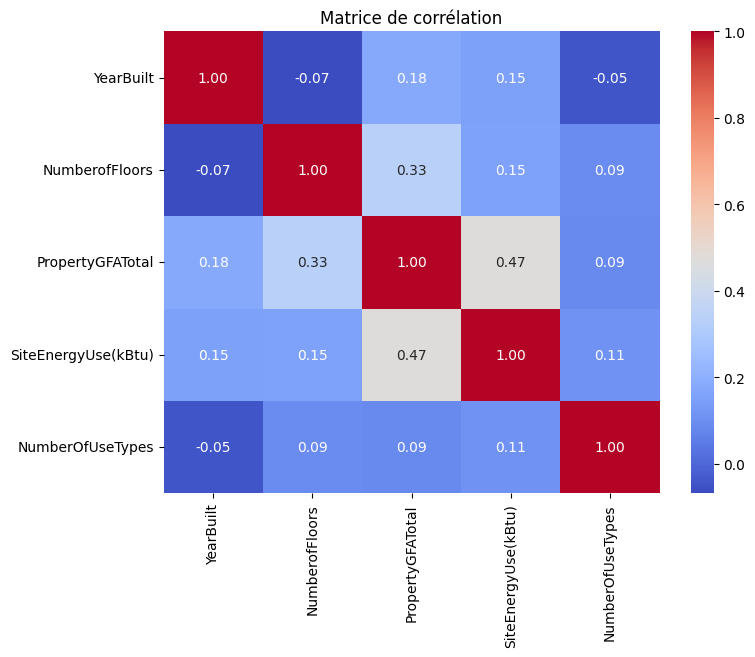

In [28]:
df_model.dropna(inplace=True)
print(f'\nDimensions finales du jeu de données : {df_model.shape}')

corr_matrix = df_model.select_dtypes(include=np.number).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

### Création du pipeline de pré-traitement

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
)

## Comparaison de plusieurs modèles supervisés

In [30]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

def safe_mape(y_true_log, y_pred_log, threshold=100):
    """
    MAPE calculé sur l'échelle originale(après expm1)
    et ignore les valeurs de y_true <threshold pour la stabilité du calcul.
    """
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    
    mask = y_true >= threshold
    
    if not np.any(mask):
        return np.nan
    
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))
  

mape_scorer = make_scorer(safe_mape, greater_is_better=False)
 
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mape': mape_scorer,
    'rmse': 'neg_root_mean_squared_error'
}

results_list = []
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    
    scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
    
    results_list.append({
        'Modèle': name,
        'R2': scores['test_r2'].mean(),
        'MAE': -scores['test_mae'].mean(),
        'MAPE': -scores['test_mape'].mean(),
        'RMSE': -scores['test_rmse'].mean()     
    })
    
results_df = pd.DataFrame(results_list).set_index('Modèle')
results_df

,R2,MAE,MAPE,RMSE
Modèle,,,,
Linear Regression,0.149886,0.807094,0.777418,1.575258
Random Forest,0.464499,0.663766,0.717365,1.206642
SVR,0.141246,0.676846,0.695986,1.600128


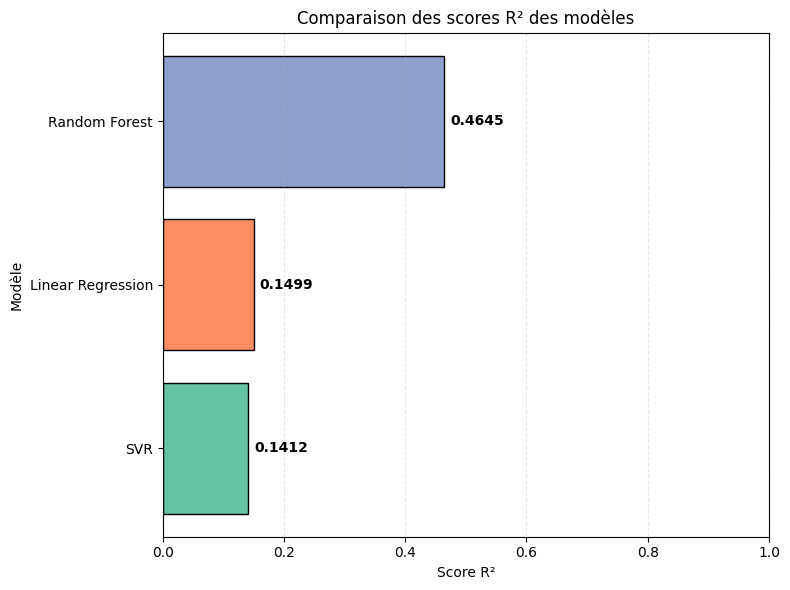

In [31]:
results_df_reset = results_df.reset_index()

plt.figure(figsize=(8, 6))
results_sorted = results_df_reset.sort_values('R2', ascending=True)

y_pos = list(range(len(results_sorted)))
values = results_sorted['R2'].tolist()
models_list = results_sorted['Modèle'].tolist()

bars = plt.barh(y_pos, values, color=sns.color_palette('Set2'), edgecolor='black', linewidth=1)

plt.title('Comparaison des scores R² des modèles')
plt.xlabel('Score R²', fontsize=10)
plt.ylabel('Modèle', fontsize=10)
plt.yticks(y_pos, models_list)
plt.xlim(0, 1)

for i, v in enumerate(values):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', ha='left', fontsize=10, fontweight='bold')

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

Le modèle **Random Forest** semble être le plus performant et le plus stable. Nous allons donc l'optimiser.

## Optimisation et interprétation du modèle

### Optimisation avec GridSearchCV

In [32]:
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('regressor', RandomForestRegressor(random_state=42))])

param_grid = {
    'regressor__n_estimators': [300, 500, 800],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [10, 20, ...], 'regressor__max_features': ['sqrt', 'log2'], 'regressor__min_samples_leaf': [1, 2, ...], 'regressor__min_samples_split': [2, 5, ...], ...}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [33]:
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score R2 (CV) : {grid_search.best_score_:.4f}")

Meilleurs paramètres : {'regressor__max_depth': 30, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 500}
Meilleur score R2 (CV) : 0.4896


### Évaluation finale sur le jeu de test

In [34]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = safe_mape(y_test, y_pred, threshold=100)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Performance du modèle final sur l'ensemble de test :")
print(f"R2 Score : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE : {mape:.4f}%")
print(f"RMSE : {rmse:.4f}")

Performance du modèle final sur l'ensemble de test :
R2 Score : 0.3009
MAE : 0.8096
MAPE : 0.6096%
RMSE : 1.7382


### Interprétation : Importance des features

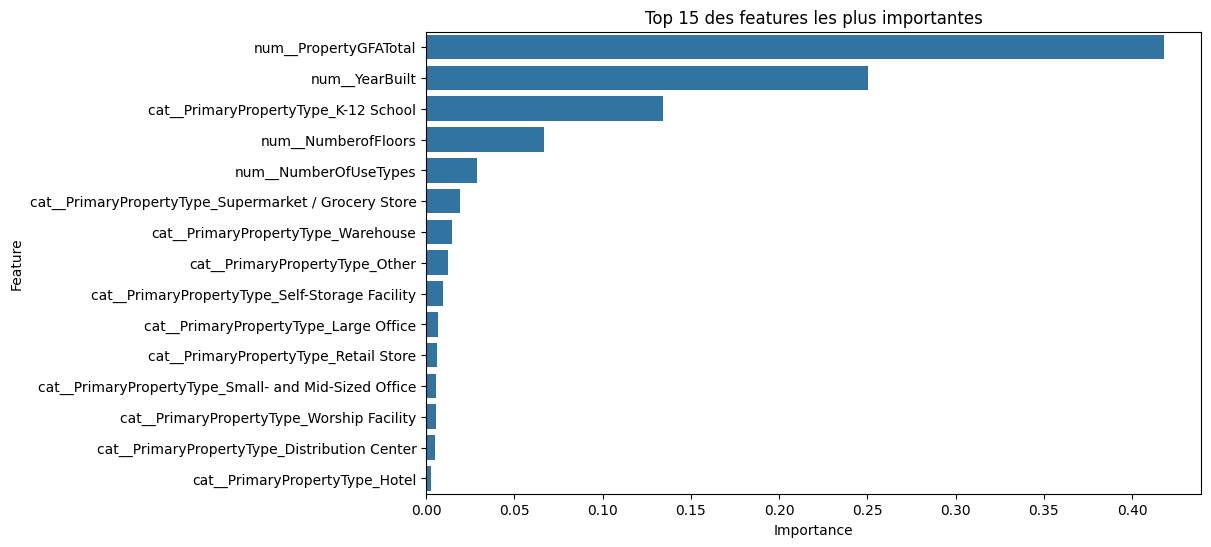

In [35]:
importances = best_model.named_steps['regressor'].feature_importances_
all_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names, 
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 des features les plus importantes')
plt.show()

# Conclusion

Nous avons développé un modèle Random Forest très performant (R² ≈ 0.48) et fiable pour prédire la consommation d'énergie. L'analyse a confirmé que la surface, le type de bâtiment et l'âge du bâtiment sont les principaux leviers.